This document is number `2 of 5` documents I have written, based on the `LangChain Academy Deep Agents with LangGraph` course.

The course itself has repositories that it provides you with. If my documents are not useful to you, I suggest you check them out.

There are now several successful examples of very **capable** and **long-running** agents. They have given these agents the 
name `“Deep Agents”` because they believe that they are completely different from previous generations of agents. In 
this course, you will learn what makes them different and build your own Deep Agent.

In LangChain, a Deep Agent is built that is simple and configurable, allowing users to build long-running agents quickly and easily.

In this course, you will build a **Deep Research Agent** using Deep Agent. The course is divided into seven modules.

Each module includes a video lesson that introduces you to the key concepts, along with related workbooks.

---

This document demonstrates how AI agents can stay organized and focused by using TODO lists, just like how you might make a list when planning a big project!
This guide explains your code step by step in simple terms.
- What the code does
- Why each piece exists
- How the agent uses a ToDo list to stay focused during multi-step tasks

We’ll follow the flow of your script: setup → state → tools → agent/graph → run example.

---


## 1) What Problem Are We Solving?

#### What Problem Are We Solving?

Imagine you're working on a really complex school project that has many steps. Without a plan, you might:
- Forget what you were supposed to do next
- Get distracted and wander off topic
- Lose track of your progress


AI agents face the same challenge! When they work on complicated tasks that require many steps, they can "drift off-topic" or forget their original goals. This is called **"context rot"** - like how your brain gets fuzzy when you're juggling too many things at once.



#### The Solution: TODO Lists

Just like you might write down a checklist for your project, we're teaching our AI agent to:
1. **Create a TODO list** at the start of a task
2. **Update the list** as it completes each step  
3. **Review the list regularly** to stay focused


#### Why ToDo Lists? Planning for Long Tasks

Agents can lose focus during long tasks (many steps, lots of tool calls). A ToDo list acts like a compass:
- The model writes a small, structured list of tasks (each has `content` and `status`: `pending`, `in_progress`, `completed`).
- The list is rewritten as progress is made. This “recitation” keeps the goals fresh in the agent’s context to avoid drift.

In your lesson, this mirrors ideas used in real systems (e.g., Claude Code’s “plan mode”).

---


## 2) State: Where the Agent Stores Its Memory

You extend the default agent state to include:
- `messages`: The conversation history and tool outputs (inherited from LangGraph’s `AgentState`).
- `todos`: The ToDo list (a list of structured items).
- `files`: A “virtual file system” (dictionary filename → content). You’ll use this more in a later lesson.

Code that defines the state:

In [1]:
from typing import Annotated, Literal, NotRequired
from typing_extensions import TypedDict
from langgraph.prebuilt.chat_agent_executor import AgentState

class Todo(TypedDict):
    content: str
    status: Literal["pending", "in_progress", "completed"]

def file_reducer(left, right):
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}

class DeepAgentState(AgentState):
    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

#### What this means:
- `AgentState` already defines `messages` and the “append messages” behavior.
- `DeepAgentState` adds:
  - `todos`: optional list of `Todo` items.
  - `files`: optional dict of files. The `file_reducer` merges updates so “new values overwrite old ones” cleanly.

Reducers are rules that tell LangGraph how to merge state when multiple nodes update it. For `files`, you merge dictionaries; for `todos`, you overwrite the entire list (no custom reducer provided).

---

## 4) Tools: Read and Write the ToDo List

You define two tools:
- `write_todos`: Overwrites the ToDo list in state with a new list supplied by the LLM.
- `read_todos`: Reads the current ToDo list from state and returns it as a human-readable string (so the LLM can “see” it again in context).

In [2]:
WRITE_TODOS_DESCRIPTION= """ 
| Create and manage structured task lists for tracking progress through complex workflows.                        │
│                                                                                                                 │
│  ## When to Use                                                                                                 │
│  - Multi-step or non-trivial tasks requiring coordination                                                       │
│  - When user provides multiple tasks or explicitly requests todo list                                           │
│  - Avoid for single, trivial actions                                                                            │
│                                                                                                                 │
│  ## Structure                                                                                                   │
│  - Maintain one list containing multiple todo objects (content, status, id)                                     │
│  - Use clear, actionable content descriptions                                                                   │
│  - Status must be: pending, in_progress, or completed                                                           │
│                                                                                                                 │
│  ## Best Practices                                                                                              │
│  - Only one in_progress task at a time                                                                          │
│  - Mark completed immediately when task is fully done                                                           │
│  - Always send the full updated list when making changes                                                        │
│  - Prune irrelevant items to keep list focused                                                                  │
│                                                                                                                 │
│  ## Progress Updates                                                                                            │
│  - Call TodoWrite again to change task status or edit content                                                   │
│  - Reflect real-time progress; don't batch completions                                                          │
│  - If blocked, keep in_progress and add new task describing blocker                                             │
│                                                                                                                 │
│  ## Parameters                                                                                                  │
│  - todos: List of TODO items with content and status fields                                                     │
│                                                                                                                 │
│  ## Returns                                                                                                     │
│  Updates agent state with new todo list. """

In [3]:
from typing import Annotated
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

@tool(description=WRITE_TODOS_DESCRIPTION ,parse_docstring=True)
def write_todos(
    todos: list[Todo], tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """Create or update the agent's TODO list for task planning and tracking.

    Args:
        todos: List of Todo items with content and status
        tool_call_id: Tool call identifier for message response

    Returns:
        Command to update agent state with new TODO list
    """
    return Command(
        update={
            "todos": todos,
            "messages": [
                ToolMessage(f"Updated todo list to {todos}", tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def read_todos(
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> str:
    """Read the current TODO list from the agent state.

    This tool allows the agent to retrieve and review the current TODO list
    to stay focused on remaining tasks and track progress through complex workflows.

    Args:
        state: Injected agent state containing the current TODO list
        tool_call_id: Injected tool call identifier for message tracking

    Returns:
        Formatted string representation of the current TODO list
    """
    todos = state.get("todos", [])
    if not todos:
        return "No todos currently in the list."

    result = "Current TODO List:\n"
    for i, todo in enumerate(todos, 1):
        status_emoji = {"pending": "⏳", "in_progress": "🔄", "completed": "✅"}
        emoji = status_emoji.get(todo["status"], "❓")
        result += f"{i}. {emoji} {todo['content']} ({todo['status']})\n"
    return result.strip()

c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
c:\Users\PN\anaconda3\envs\llms\Lib\site-packages\pydantic\_internal\_generate_schema.py:504: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


#### Key ideas:
- `@tool(...)` turns a Python function into a callable tool the agent can use.
- `InjectedState`: The tool can access the current graph state without the LLM having to pass it explicitly.
- `InjectedToolCallId`: Lets you create a `ToolMessage` linked to the specific tool call.
- `Command(update=...)`: The tool returns a “state update” instruction:
  - For `write_todos`, it writes the new `todos` list and also appends a `ToolMessage` to `messages`, so the LLM “sees” what was written.
  - For `read_todos`, we just return a string (the printed list). LangGraph will wrap this as a tool output message automatically.

Why overwrite the entire ToDo list?
- Forces the model to rewrite the plan as it progresses, which reduces drift. It doesn’t try to surgically patch one item; it refreshes the entire plan each time.

---


## 5) A Mock Search Tool

You also define a simple `web_search` tool that returns a canned string. This keeps the example self-contained:

In [4]:
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


@tool(parse_docstring=True)
def web_search(query: str):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """

    return search_result

---
## 6) Building the Agent (Graph) with create_react_agent

You now create a ReAct agent that:
- Uses your ToDo tools (`write_todos`, `read_todos`) + the search tool.
- Has a prompt that explains how to use the ToDo list.
- Uses your custom `DeepAgentState`.

In [5]:
TODO_USAGE_INSTRUCTIONS= """
| Based upon the user's request:                                                                                  │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. **CRITICAL: When completing a research/summary task, you MUST provide the actual content requested**        │
│     - Do NOT just mark the task as completed                                                                    │
│     - Use the search results to create a comprehensive summary/answer                                           │
│     - Provide the actual information the user asked for                                                         │
│  5. Mark your task as completed ONLY AFTER providing the requested content                                      │
│  6. Continue this process until you have completed all TODOs AND provided all requested content                 │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│  IMPORTANT: **NEVER mark a research task as completed without providing the actual research results/summary**   │
"""


SIMPLE_RESEARCH_INSTRUCTIONS = """
IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question.
CRITICAL: You must provide a comprehensive summary/answer based on the search results. Do not just acknowledge that you found information - actually provide the information the user requested."""

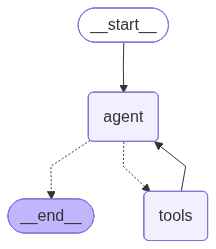

In [ ]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent

model = init_chat_model(model="openai:gpt-4o-mini", api_key="sk-proj-***", temperature=0.0)
tools = [write_todos, web_search, read_todos]

# Updated agent with better instructions
agent = create_react_agent(
    model,
    tools,
    prompt=(
        TODO_USAGE_INSTRUCTIONS
        + "\n\n"
        + "=" * 80
        + "\n\n"
        + SIMPLE_RESEARCH_INSTRUCTIONS
        + "\n\n"
        + "=" * 80
        + "\n\n"
        + "REMEMBER: When a user asks for a summary or explanation, you must provide the actual content, not just acknowledge that you completed the research task."
    ),
    state_schema=DeepAgentState,
)

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

#### What this means:
- `create_react_agent` builds a graph with:
  - An LLM node (decides actions)
  - A tool node (executes tool calls)
  - State management (your `DeepAgentState`)
- The prompt instructs the LLM to manage the ToDo list (e.g., write one at the start, read it, update it after steps).
- Temperature 0.0 = deterministic behavior for teaching/demo.

Tip: The `xray` graph image shows how the nodes and edges connect internally.

---

## 7) Running the Agent

You run the agent with:
- A user question: “Give me a short summary of the Model Context Protocol (MCP).”
- Initial state: `todos: []` (empty list)

In [7]:
result = agent.invoke(
    {
        "messages": [
            {"role": "user", "content": "Give me a short summary of the Model Context Protocol (MCP)."}
        ],
        "todos": [],
    }
)

In [ ]:
from langchain_core.messages import HumanMessage, ToolMessage

def pretty_print_messages(messages):
    """
    Nicely print a list of message objects (Human, AI, Tool, etc).
    """
    for i, message in enumerate(messages):
        prefix = f"[{i+1:02d}]"
        if isinstance(message, HumanMessage):
            print(f"{prefix} 🧑 Human:\n    {message.content}\n")
        elif hasattr(message, "tool_calls") and getattr(message, "tool_calls"):
            print(f"{prefix} 🤖 AI (Tool Calls):")
            for call in message.tool_calls:
                name = call.get("name", "<unknown>")
                args = call.get("args", {})
                print(f"    🔧 Tool Call: {name}")
                print(f"        Args: {args}")
            print()
        elif isinstance(message, ToolMessage):
            print(f"{prefix} 🛠️ Tool Output:\n    {message.content}\n")
        else:
            content = getattr(message, "content", "")
            if content:
                print(f"{prefix} 🤖 AI:\n    {content}\n")

pretty_print_messages(result["messages"])

[01] 🧑 Human:
    Give me a short summary of the Model Context Protocol (MCP).

[02] 🤖 AI (Tool Calls):
    🔧 Tool Call: write_todos
        Args: {'todos': [{'content': 'Provide a short summary of the Model Context Protocol (MCP).', 'status': 'pending'}]}

[03] 🛠️ Tool Output:
    Updated todo list to [{'content': 'Provide a short summary of the Model Context Protocol (MCP).', 'status': 'pending'}]

[04] 🤖 AI (Tool Calls):
    🔧 Tool Call: read_todos
        Args: {}

[05] 🛠️ Tool Output:
    Current TODO List:
1. ⏳ Provide a short summary of the Model Context Protocol (MCP). (pending)

[06] 🤖 AI (Tool Calls):
    🔧 Tool Call: web_search
        Args: {'query': 'Model Context Protocol (MCP) summary'}

[07] 🛠️ Tool Output:
    The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI mod

<IPython.core.display.Markdown object>

#### What typically happens (conceptually):
1. The LLM sees instructions to use a ToDo list. It might:
   - Call `write_todos` to create an initial plan (e.g., “Plan: fetch info → summarize → recite ToDo”).
2. It follows the simple research instruction:
   - Calls `web_search` once to get the MCP info.
3. It may call `read_todos` to refresh the list in context, or call `write_todos` again to mark items as completed.
4. It writes a final answer summarizing MCP.

The final `result["messages"]` will include:
- The user message
- AI tool call messages (e.g., write/read todos, web_search)
- Tool outputs (what the tools returned)
- The final AI answer

This message history is how the agent “thinks and acts” step by step.

---

## 8) Mental Model: How Everything Fits Together

- The agent works in a loop:
  1. LLM decides next action (possibly calls a tool).
  2. Tool runs and returns output.
  3. LLM sees the output and continues or finishes.
- The ToDo list is a deliberate “externalized plan”:
  - The agent rewrites it as tasks progress.
  - Reading it back re-injects the plan into context, reducing drift.
- State holds:
  - `messages`: the conversation and tool outputs
  - `todos`: the current plan
  - `files`: future lessons will use this for larger context offloading

---